In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_write
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from captum.attr import FeaturePermutation, ShapleyValueSampling, IntegratedGradients, FeatureAblation
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False

In [3]:
config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",],# 'sat_SZA', 'sat_AZI', 'coscatter_angle'],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)

trans = {
            "VIS006": "channel_1",
            "VIS008": "channel_2",
            "IR_016": "channel_3",
            "IR_039": "channel_4",
            "WV_062": "channel_5",
            "WV_073": "channel_6",
            "IR_087": "channel_7",
            "IR_097": "channel_8",
            "IR_108": "channel_9",
            "IR_120": "channel_10",
            "IR_134": "channel_11",
            "DEM":"DEM",
}

inv_trans = {v: k for k, v in trans.items()}
x_vars_trans = [inv_trans[nm] for nm in config.x_vars]

In [4]:


# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/4nbyae30/checkpoints/epoch=5-val_loss=0.01038.ckpt'# SARAH3 emulator
# chkpt_fn = '../train/SIS_point_estimation_groundstation/pl86of1b/checkpoints/epoch=4-val_loss=0.01630.ckpt' # finetuned on 80 DWD groundstations
# chkpt_fn = '../train/SIS_point_estimation_groundstation/groundstations_only/checkpoints/epoch=10-val_loss=0.01703.ckpt' # trained only on 80 DWD groundstations
# chkpt_fn = '../train/SIS_point_estimation_groundstation/drvowqn4/checkpoints/epoch=0-val_loss=0.01659.ckpt' # finetuned DWD, freeze MLP


#### TEST coscatterangle 
# coscatter dwd
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation//train/SIS_point_estimation_groundstation/2oys35k3/checkpoints/epoch=6-step=14469.ckpt' # finetuned DWD, freeze MLP
# coscatter bsrn
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/xqklgx75/checkpoints/epoch=6-step=1274.ckpt'

### emulator
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/jup3gn3n/checkpoints/epoch=1-val_loss=0.00705.ckpt'

### Finetuned
chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/hmobjerd/checkpoints/epoch=1-bsrnval_loss/dataloader_idx_1=0.01771-dwdval_loss/dataloader_idx_0=0.01761.ckpt'

inference_fn = chkpt_fn.split('checkpoints')[0] + 'inference/'
run_id = chkpt_fn.split('/checkpoints')[0].split('/')[-1]
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)


estimator = LitEstimatorPoint.load_from_checkpoint(chkpt_fn,)
estimator.eval()
print(run_id)
save_path = f'feature_importance/{run_id}/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

hmobjerd


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


In [5]:
def get_gsdataset(fn):
    return GroundstationDataset(fn, config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                   config.transform, config.target_transform, sarah_idx_only=True)


# TAT_fn = '../../ZARR/IEA_PVPS/IEA_PVPS-TAT.zarr'
# CAB_fn = '../../ZARR/IEA_PVPS/IEA_PVPS-CAB.zarr'
# TAT = get_gsdataset(TAT_fn)
# CAB = get_gsdataset(CAB_fn)

bsrn_fns = glob('/scratch/snx3000/kschuurm/ZARR/IEA_PVPS/IEA_PVPS_*.zarr')
bsrn_datasets = {fn.split('PVPS_')[-1].replace('.zarr', ''):get_gsdataset(fn) for fn in tqdm(bsrn_fns)}
bsrn_dataset_all = ConcatDataset(bsrn_datasets.values())


100%|██████████| 14/14 [00:36<00:00,  2.61s/it]


In [9]:
dl_all = DataLoader(bsrn_dataset_all, shuffle=True, batch_size=20000)


In [10]:

patch = torch.ones((15,15))
X_feature_mask = torch.stack([patch *i for i in range(len(config.x_vars))]).unsqueeze(0).to(torch.int) # 1 x 12 x 15 x 15
x_feature_mask = torch.tensor(range(len(config.x_features))).unsqueeze(0).to(torch.int) # 1 x 5
feature_mask = (X_feature_mask, x_feature_mask) 

In [11]:

# metric = MeanSquaredError().cuda()
metric = MeanAbsoluteError().cuda()

@torch.no_grad()
def forward_func(X, x, y):
    y_hat = estimator(X.cuda(),x.cuda())
    y = y.cuda()
    y_hat = config.transform.inverse(y_hat, ['SIS'])
    y = config.transform.inverse(y, ['SIS'])
    loss = metric(y,y_hat)
    # prediction_error_plot(config.transform.inverse(y, ['SIS']),config.transform.inverse(y_hat, ['SIS']))
    # print(loss)
    return loss

feature_perm = FeaturePermutation(forward_func)

# for X,x,y in dl:
#     forward_func(X,x,y)

In [12]:
def feature_importance_dl(dl):
    x_attrs = []
    X_attrs = []

    for X, x, y in tqdm(dl):

        X_attr, x_attr = feature_perm.attribute((X,x), feature_mask=feature_mask, additional_forward_args=y)
        X_attr_channel = -1*X_attr.mean(dim=(2,3)).squeeze()
        x_attr = -1*x_attr.squeeze()
        x_attrs.append(x_attr)
        X_attrs.append(X_attr_channel)
    
    return X_attrs, x_attrs

X_attrs, x_attrs = feature_importance_dl(dl_all)


100%|██████████| 19/19 [02:29<00:00,  7.89s/it]


In [13]:
X_attrs_all = torch.stack(X_attrs)
x_attrs_all = torch.stack(x_attrs)

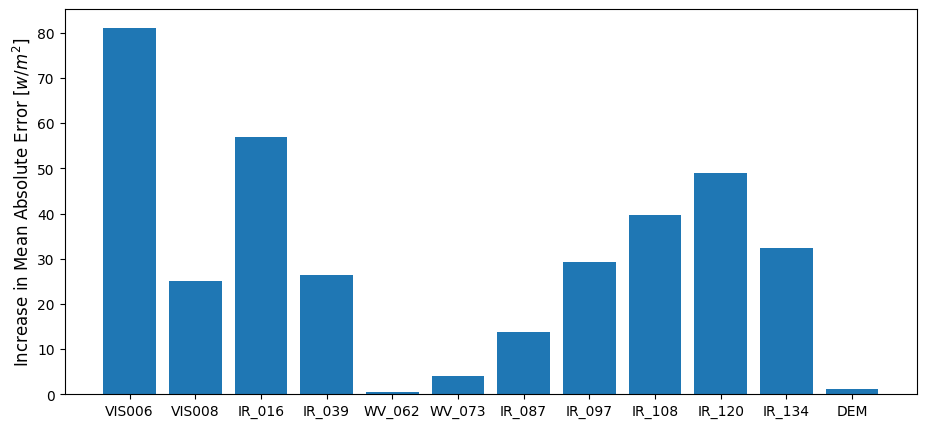

In [14]:
X_attrs_max = X_attrs_all.max(axis=0).values
X_attrs_min = X_attrs_all.min(axis=0).values

x_attrs_max = x_attrs_all.max(axis=0).values
x_attrs_min = x_attrs_all.min(axis=0).values

X_attrs_all_watt = X_attrs_all.mean(0)

plt.figure(figsize=(11,5))
plt.bar(x_vars_trans, X_attrs_all_watt)
plt.ylabel('Increase in Mean Absolute Error $[w/m^2]$', fontsize=12)
# plt.errorbar(x_vars_trans, X_attrs_all.mean(0), yerr=torch.stack((X_attrs_max, X_attrs_min)),  fmt='.', color='Black', elinewidth=2,capthick=2,errorevery=1, alpha=0.5, ms=4, capsize = 2)
# plt.scatter(x_vars_trans, X_attrs_max, c='k', marker='_')
# plt.scatter(x_vars_trans, X_attrs_min, c='k', marker='_')
# plt.vlines(x_vars_trans, ymin = X_attrs_min, ymax = X_attrs_max, color='k')

plt.savefig( save_path + 'X_attrs.png')

In [15]:
x_attrs_all.std(0)

tensor([0.0284, 0.0298, 0.0096, 1.4028, 0.2205])

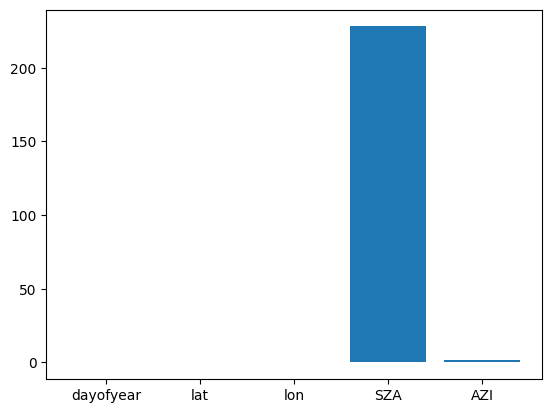

In [16]:
plt.bar(config.x_features, x_attrs_all.mean(0))
# plt.scatter(config.x_features, x_attrs_max, c='k', marker='_')
# plt.scatter(config.x_features, x_attrs_min, c='k', marker='_')
# plt.vlines(config.x_features, ymin = x_attrs_min, ymax = x_attrs_max, color='k')
# # plt.ylim([0,0.01])
plt.savefig(save_path + 'x_attrs.png')

In [ ]:
for nm, ds in bsrn_datasets.items():
    
    dl = DataLoader(ds, shuffle=False, batch_size=10000)
    X_attrs, x_attrs = feature_importance_dl(dl)
    
    X_attrs_all = torch.stack(X_attrs)
    x_attrs_all = torch.stack(x_attrs)
    
    X_attrs_max = X_attrs_all.max(axis=0).values
    X_attrs_min = X_attrs_all.min(axis=0).values

    x_attrs_max = x_attrs_all.max(axis=0).values
    x_attrs_min = x_attrs_all.min(axis=0).values

    plt.figure(figsize=(11,5))
    plt.bar(x_vars_trans, X_attrs_all.mean(0),)
    # plt.scatter(x_vars_trans, X_attrs_max, c='k', marker='_')
    # plt.scatter(x_vars_trans, X_attrs_min, c='k', marker='_')
    # plt.vlines(x_vars_trans, ymin = X_attrs_min, ymax = X_attrs_max, color='k')
    plt.savefig( save_path + f'{nm}_X_attrs.png')
    
    plt.figure()
    plt.bar(config.x_features, x_attrs_all.mean(0))
    # plt.scatter(config.x_features, x_attrs_max, c='k', marker='_')
    # plt.scatter(config.x_features, x_attrs_min, c='k', marker='_')
    # plt.vlines(config.x_features, ymin = x_attrs_min, ymax = x_attrs_max, color='k')
    plt.savefig(save_path + f'{nm}_x_attrs.png')

# Pixel importance

In [22]:
patch = torch.arange(0, 15*15).view(15,15)
print(patch)
X_feature_mask = torch.stack([patch for i in range(len(config.x_vars))]).unsqueeze(0).to(torch.int) # 1 x 12 x 15 x 15
x_feature_mask = torch.ones(5).unsqueeze(0).to(torch.int) # 1 x 5
feature_mask = (X_feature_mask, x_feature_mask) 
print(X_feature_mask.shape, x_feature_mask.shape)

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14],
        [ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29],
        [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
          44],
        [ 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
          59],
        [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
          74],
        [ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
          89],
        [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104],
        [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
         119],
        [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
         134],
        [135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
         149],
        [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 1

In [23]:
def feature_importance_dl(dl):
    x_attrs = []
    X_attrs = []

    for X, x, y in tqdm(dl):

        X_attr, x_attr = feature_perm.attribute((X,x), feature_mask=feature_mask, additional_forward_args=y)
        X_attr_channel = -1*X_attr.mean(dim=1).squeeze()
        x_attr = -1*x_attr.squeeze()
        x_attrs.append(x_attr)
        X_attrs.append(X_attr_channel)
    
    return X_attrs, x_attrs

X_attrs, x_attrs = feature_importance_dl(dl_all)

100%|██████████| 19/19 [29:24<00:00, 92.88s/it]


In [26]:
X_attrs_all = torch.stack(X_attrs)
x_attrs_all = torch.stack(x_attrs)
X_attrs_all.shape

torch.Size([19, 15, 15])

In [33]:
X_attrs_all.max(0)

torch.return_types.max(
values=tensor([[ 1.5739e-02,  1.2356e-02, -1.1078e-02, -3.4523e-03,  1.8738e-02,
          6.2485e-03, -2.2846e-02, -3.2337e-02, -2.8309e-02, -1.8135e-02,
         -1.0933e-02, -1.8124e-02, -4.6806e-03, -3.8029e-02, -2.0344e-02],
        [-2.7592e-02,  1.4229e-03, -4.2618e-02,  1.6964e-02, -3.7155e-03,
         -4.8409e-03, -4.0565e-02, -4.4521e-02, -6.9427e-02, -4.9110e-02,
          1.1768e-02,  2.0382e-02,  1.8570e-02, -1.4339e-02,  2.3842e-03],
        [-1.2508e-02, -8.8882e-03,  3.2318e-02,  2.5856e-02,  3.4645e-02,
         -1.8120e-03,  1.4084e-02, -5.1029e-02, -4.3106e-02, -2.9709e-02,
          3.3115e-02,  2.2537e-02,  4.7749e-02, -6.1073e-03,  5.1346e-03],
        [-8.2436e-03,  6.5666e-02,  7.9475e-02,  9.5772e-02,  9.4448e-02,
          7.9674e-02,  4.1443e-02, -1.3821e-02, -2.8725e-02, -2.0496e-02,
         -1.1814e-02, -6.8665e-03,  2.3048e-02, -1.7258e-02, -3.0136e-03],
        [ 1.6491e-02,  5.0739e-02,  1.4506e-01,  9.7157e-02,  1.1847e-01,
   

tensor(0.2193)

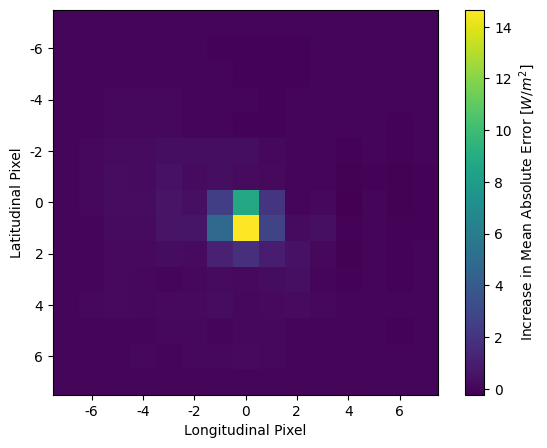

In [60]:
plt.figure(figsize=(7,5))
plt.imshow(X_attrs_all.mean(dim=0))
plt.colorbar(label='Increase in Mean Absolute Error $[W/m^2]$')
plt.xlabel('Longitudinal Pixel')
_ = plt.xticks(ticks = np.arange(1, 14,2), labels=np.arange(-6, 7, 2))
plt.ylabel('Latitudinal Pixel')
_ = plt.yticks(ticks = np.arange(1, 14,2), labels=np.arange(-6, 7, 2))
plt.savefig(save_path + f'pixels.png')

# testing

In [ ]:


featureab = FeatureAblation(forward_func)
                                
X_attr, x_attr = featureab.attribute((X,x), feature_mask=feature_mask, additional_forward_args=y)
X_attr_channel = X_attr.mean(dim=(2,3)).squeeze()


In [ ]:
plt.figure(figsize=(11,5))
plt.bar(x_vars_trans, X_attr_channel)

In [ ]:
plt.bar(config.x_features, x_attr.squeeze())

In [ ]:
def forward_func_grad(X, x, y):
    y_hat = estimator(X.cuda(),x.cuda())
    y = y.cuda()
    loss = metric(y,y_hat)
    return loss


intgrad = IntegratedGradients(forward_func_grad)

In [ ]:
dl = DataLoader(TAT, shuffle=False, batch_size=100)
for X,x,y in dl:
    break

intgrad.attribute((X,x),  additional_forward_args=y)